In [1]:
#!pip install mysql.connector
#!pip install tpot
#!pip install cuml
!conda install -c conda-forge xgboost_gpu

done
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
WARNING conda.models.version:get_matcher(556): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.9.0.*, but conda is ignoring the .* and treating it as 1.9.0
WARNING conda.models.version:get_matcher(556): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
done
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - xgboost_gpu

Current channels:

  - https://conda.anaconda.org/conda-forge/linux-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/mai

In [1]:
import mysql.connector
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
import tensorflow
from keras.layers import GRU, Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense

2023-12-06 09:17:12.099257: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 09:17:12.123692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 09:17:12.123705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 09:17:12.124321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 09:17:12.128040: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 09:17:12.128335: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Ensemble Model

### Getting the counts of each attack

In [2]:
con = mysql.connector.connect(
    host = "localhost",
    user = "root",
    passwd = "G5thesis",
    database = "dataset_NF"
)
cursor = con.cursor()

In [3]:
query = f"SELECT {'Attack'}, COUNT(*) FROM {'Encoded_L7_DstPrt_Cleaned_NF_dataset'} GROUP BY {'Attack'}"
cursor.execute(query)
results = cursor.fetchall()
values = []
counts = []
results = sorted(results,key = lambda x: x[1],reverse = True)
# Print the results
for result in results:
    values.append(result[0])
    counts.append(result[1])

### Visualization

In [4]:
key = {0:'Benign',
       1: 'Bot',
       2: 'BruteForce - Web',
       3: 'BruteForce - XSS',
       4: 'DDoS Attacks - HOIC',
       5: 'DDoS Attacks - LOIC -UDP',
       6: 'DDoS Attacks - LOIC - HTTP',
       7: 'DoS Attacks - GoldenEye',
       8: 'DoS Attacks - Hulk',
       9: 'DoS Attacks - SlowHTTPTest',
      10: 'DoS Attacks - Slowloris',
      11: 'FTP - BruteForce',
      12: 'Infiltration',
      13: 'SQL Injection',
      14: 'SSH - BruteForce'
      }

In [5]:
attacks = []
for i in range(15):
    attacks.append(key[values[i]])


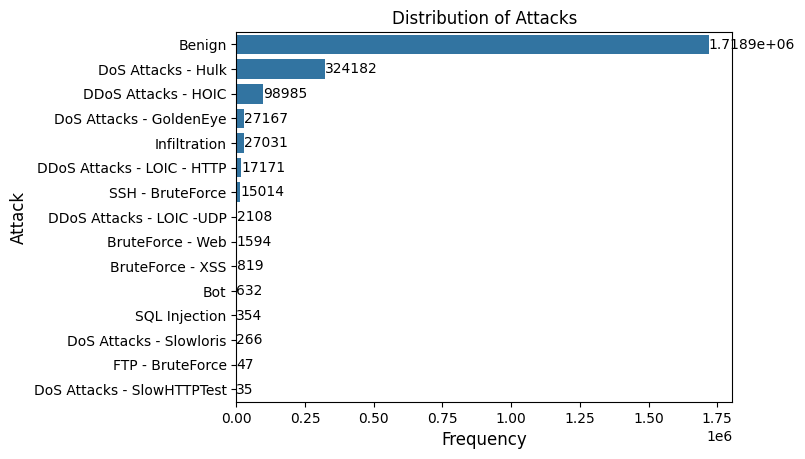

In [6]:
palette_color = sns.color_palette('dark',len(counts))
ax = sns.barplot(x=counts,y=attacks,orient = 'h')
ax.bar_label(ax.containers[0],fontsize = 10)
plt.title('Distribution of Attacks')
plt.xlabel('Frequency',fontsize = 12)
plt.ylabel('Attack',fontsize = 12)
plt.savefig('Bar Plot of Attacks.png')
plt.show()

### Loading the Binary Classifiers

In [7]:
models = []
names = []
for i in range(0,15):
    with open('M_Model_' + str(i)+'.pkl', 'rb') as file:
        models.append(pickle.load(file))
        names.append('M_Model_' + str(i))

In [8]:
con = mysql.connector.connect(
    host = "localhost",
    user = "root",
    passwd = "G5thesis",
    database = "dataset_NF"
)
cursor = con.cursor()
q1 = "DESCRIBE Encoded_L7_DstPrt_Cleaned_NF_dataset"
cursor.execute(q1)
colnames = [row[0] for row in cursor.fetchall()]

In [9]:
# Extract all the data
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
data = []
for i in labels:
    cursor.execute("""SELECT * FROM Encoded_L7_DstPrt_Cleaned_NF_dataset WHERE Attack = %s ORDER BY RAND() """,(i,))
    rows = cursor.fetchall()
    data.extend(rows)
df = pd.DataFrame(data = data, columns = colnames)
df.head()

,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,...,L4_DST_PORT_3306,L4_DST_PORT_8080,L4_DST_PORT_31808,L4_DST_PORT_OTHERS,L7_PROTO_7,L7_PROTO_79,L7_PROTO_92,L7_PROTO_131,L7_PROTO_178,L7_PROTO_OTHERS
0,1386,18,36148,34,219,219,27,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,40,1,0,0,2,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,61,1,241,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,5030,65,67643,101,31,31,27,4294951,16,16,...,0,0,0,0,0,0,0,0,0,1
4,1700,24,17228,26,219,219,27,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [10]:
df.columns

Index(['IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS',
       'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS',
       'DURATION_IN', 'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT',
       'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN',
       'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'DNS_TTL_ANSWER', 'Attack', 'L4_DST_PORT_21', 'L4_DST_PORT_22',
       'L4_DST_PORT_67', 'L4_DST_PORT_80', 'L4_DST_PORT_443',
       'L4_DST_PORT_500', 'L4_DST_PORT_3306', 'L4_DST_PORT_8080',
       'L4_DST_PORT_31808', 'L4_DST_PORT_OTHERS', 'L7_PROTO_7', 'L7_PROTO_79',
       'L7_PROTO_92', 'L7_PROTO_131', 'L7_PROTO_178', 'L7_PROTO_OTHERS'],
      dtype='object')

### Binary Classifiers Output for the Data

In [11]:
def binary_classifiers(data,Y,option=0): 
    no_of_rows = 15
    no_of_cols = 59
    predictions = np.empty((0, len(data)))
    # Binary Classifiers
    for i in tqdm(range(15)):
        result = np.array((models[i].predict(data)))
        predictions = np.vstack((predictions, result))
    predictions = np.transpose(predictions)
    predictions = pd.concat([pd.DataFrame(predictions), data], axis=1)
    if option == 0:
        with open('X-train.pkl', 'wb') as file: 
            pickle.dump(predictions, file)
        with open('Y-train.pkl','wb') as file: 
            pickle.dump(Y, file)
    if option:
        with open('X-test.pkl', 'wb') as file: 
            pickle.dump(predictions, file)
        with open('Y-test.pkl','wb') as file: 
            pickle.dump(Y, file)

In [12]:
X = df.drop(columns = ['Attack'])
Y = df[['Attack']]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, random_state = 30,stratify=Y)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

/home/sharaf/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/sharaf/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/sharaf/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [13]:
X_train

,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,...,L4_DST_PORT_3306,L4_DST_PORT_8080,L4_DST_PORT_31808,L4_DST_PORT_OTHERS,L7_PROTO_7,L7_PROTO_79,L7_PROTO_92,L7_PROTO_131,L7_PROTO_178,L7_PROTO_OTHERS
0,40,1,0,0,2,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,44,1,0,0,2,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1767,15,3609,15,27,27,27,4294858,109,109,...,0,0,0,0,1,0,0,0,0,0
3,521,5,1147,5,219,219,27,4294862,104,104,...,0,0,0,0,1,0,0,0,0,0
4,523,5,1147,5,219,219,27,4294848,119,119,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787443,2495,21,5380,20,219,219,27,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1787444,68,1,125,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1787445,2323,22,6863,20,219,219,27,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1787446,78,1,160,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [14]:
X_train.shape

(1787448, 44)

In [15]:
X_test.shape

(446862, 44)

In [16]:
y_train.shape

(1787448, 1)

In [17]:
y_test.shape

(446862, 1)

In [18]:
# Training the model
warnings.filterwarnings('ignore') 
# no need to run this again
binary_classifiers(X_train,y_train)
binary_classifiers(X_test,y_test,1)

100%|███████████████████████████████████████████| 15/15 [00:25<00:00,  1.71s/it]


### Using New Dataset For Several Models

In [19]:
with open('X-train.pkl', 'rb') as file:
    X_train2 = pickle.load(file)
with open('Y-train.pkl', 'rb') as file:
    Y_train2 = pickle.load(file)
with open('X-test.pkl', 'rb') as file:
    X_test2 = pickle.load(file)
with open('Y-test.pkl', 'rb') as file:
    Y_test2 = pickle.load(file)

#### Random Forest Model

In [23]:
X_train2 = np.array(X_train2)
Y_train2 = np.array(Y_train2)
X_test2 = np.array(X_test2)
Y_test2 = np.array(Y_test2)

In [24]:
rf = RandomForestClassifier(n_estimators=200, random_state=35, class_weight='balanced')
# Train the classifier
rf.fit(X_train2, Y_train2)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=35)

In [25]:
y_pred = rf.predict(X_test2)
results = classification_report(Y_test2,y_pred,output_dict = True)
results = pd.DataFrame(results).transpose()
results

,precision,recall,f1-score,support
0,0.991202,0.987454,0.989325,343781.000000
1,1.000000,1.000000,1.000000,126.000000
2,0.065744,0.059561,0.062500,319.000000
3,0.111732,0.121951,0.116618,164.000000
4,0.980687,0.979795,0.980241,19797.000000
5,0.997625,0.995261,0.996441,422.000000
6,0.999418,0.999709,0.999563,3434.000000
7,1.000000,1.000000,1.000000,5434.000000
8,1.000000,0.999969,0.999985,64836.000000
9,1.000000,1.000000,1.000000,7.000000


#### XGB Model

##### Trial 1: 

In [21]:
xgb_model = xgb.XGBClassifier(num_class=15, n_estimators = 200)
xgb_model.fit(X_train2, Y_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=15,
              num_parallel_tree=None, ...)

In [22]:
y_pred = xgb_model.predict(X_test2)
results = classification_report(Y_test2,y_pred,output_dict = True)
results = pd.DataFrame(results).transpose()
results

,precision,recall,f1-score,support
0,0.990473,0.998848,0.994643,343781.000000
1,1.000000,1.000000,1.000000,126.000000
2,0.362069,0.065831,0.111406,319.000000
3,0.593750,0.115854,0.193878,164.000000
4,0.976395,0.998737,0.987440,19797.000000
5,0.992925,0.997630,0.995272,422.000000
6,0.999417,0.999126,0.999272,3434.000000
7,1.000000,1.000000,1.000000,5434.000000
8,1.000000,0.999969,0.999985,64836.000000
9,1.000000,1.000000,1.000000,7.000000


##### Trial 2: 

In [30]:
xgb_model = xgb.XGBClassifier(objective ='multi:softmax', num_class=15, colsample_bytree = 0.3, 
                           learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 200)
xgb_model.fit(X_train2, Y_train2)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=15, ...)

In [31]:
y_pred = xgb_model.predict(X_test2)
results = classification_report(Y_test2,y_pred,output_dict = True)
results = pd.DataFrame(results).transpose()
results

,precision,recall,f1-score,support
0,0.990621,0.998854,0.994721,343781.000000
1,1.000000,1.000000,1.000000,126.000000
2,0.750000,0.065831,0.121037,319.000000
3,0.904762,0.115854,0.205405,164.000000
4,0.976135,1.000000,0.987924,19797.000000
5,1.000000,0.983412,0.991637,422.000000
6,0.997965,0.999418,0.998691,3434.000000
7,1.000000,0.999632,0.999816,5434.000000
8,1.000000,0.999969,0.999985,64836.000000
9,1.000000,1.000000,1.000000,7.000000


#### GRU Model

In [13]:
X_train2 = X_train2.reshape((X_train2.shape[0], X_train2.shape[1], 1))

In [14]:
X_train2.shape

(1787448, 59, 1)

In [15]:
Y_train2 = Y_train2.reshape((Y_train2.shape[0], Y_train2.shape[1], 1))

In [16]:
Y_train2.shape

(1787448, 1, 1)

In [17]:
warnings.filterwarnings('ignore') 

# Define the model
model = Sequential()

# Add the first GRU layer with 32 units and dropout
model.add(GRU(32, input_shape=(X_train2.shape[1], X_train2.shape[2]), return_sequences=True))
# model.add(Dropout(0.5))

# Add the second GRU layer with 64 units and dropout
model.add(GRU(64, return_sequences=True))
# model.add(Dropout(0.5))

# Add the third GRU layer with 128 units and dropout
model.add(GRU(128))
model.add(Dropout(0.5))

# Add the final softmax layer for classification
model.add(Dense(15, activation='softmax'))

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model.summary()

2023-11-28 09:56:04.718958: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 09:56:04.719137: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 09:56:04.722820: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required l

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 59, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 59, 64)            18816     
                                                                 
 gru_2 (GRU)                 (None, 128)               74496     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
Total params: 98607 (385.18 KB)
Trainable params: 98607 (385.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
X_train2.shape

(1787448, 59, 1)

In [65]:
Y_train2.shape

(1787448, 1, 1)

In [290]:
warnings.filterwarnings('ignore') 
# Train the model
model.fit(X_train2, Y_train2, epochs=100, batch_size=1024)

Epoch 1/100
1746/1746 [==============================] - 381s 218ms/step - loss: 0.1040 - accuracy: 0.9751
Epoch 2/100
1746/1746 [==============================] - 384s 220ms/step - loss: 0.1074 - accuracy: 0.9755
Epoch 3/100
1746/1746 [==============================] - 384s 220ms/step - loss: 0.1465 - accuracy: 0.9615
Epoch 4/100
1746/1746 [==============================] - 384s 220ms/step - loss: 0.1006 - accuracy: 0.9776
Epoch 5/100
1746/1746 [==============================] - 384s 220ms/step - loss: 0.0616 - accuracy: 0.9831
Epoch 6/100
1746/1746 [==============================] - 384s 220ms/step - loss: 0.0372 - accuracy: 0.9882
Epoch 7/100
1746/1746 [==============================] - 383s 220ms/step - loss: 0.0342 - accuracy: 0.9892
Epoch 8/100
1746/1746 [==============================] - 384s 220ms/step - loss: 0.0698 - accuracy: 0.9810
Epoch 9/100
1746/1746 [==============================] - 384s 220ms/step - loss: 0.0608 - accuracy: 0.9804
Epoch 10/100
1746/1746 [=============

Epoch 77/100
1746/1746 [==============================] - 385s 221ms/step - loss: 0.0291 - accuracy: 0.9903
Epoch 78/100
1746/1746 [==============================] - 386s 221ms/step - loss: 0.0289 - accuracy: 0.9903
Epoch 79/100
1746/1746 [==============================] - 386s 221ms/step - loss: 0.0288 - accuracy: 0.9904
Epoch 80/100
1746/1746 [==============================] - 385s 221ms/step - loss: 0.0287 - accuracy: 0.9905
Epoch 81/100
1746/1746 [==============================] - 386s 221ms/step - loss: 0.0412 - accuracy: 0.9878
Epoch 82/100
1746/1746 [==============================] - 387s 222ms/step - loss: 0.0301 - accuracy: 0.9901
Epoch 83/100
1746/1746 [==============================] - 385s 221ms/step - loss: 0.0290 - accuracy: 0.9903
Epoch 84/100
1746/1746 [==============================] - 385s 221ms/step - loss: 0.0288 - accuracy: 0.9905
Epoch 85/100
1746/1746 [==============================] - 386s 221ms/step - loss: 0.0286 - accuracy: 0.9905
Epoch 86/100
1746/1746 [====

In [20]:
X_test = X_test2.reshape((X_test2.shape[0], X_test2.shape[1], 1))
# Make predictions
y_pred = model.predict(X_test)
print(y_pred.shape)
# Convert predictions to class labels
y_pred_classes = tf.argmax(y_pred, axis=1)

13965/13965 [==============================] - 109s 8ms/step
(446862, 15)


In [293]:
# Print classification report
results = classification_report(y_test, y_pred_classes, output_dict=True)
df_res = pd.DataFrame(results).transpose()
print(df_res)

              precision    recall  f1-score        support
0              0.990835  0.998802  0.994802  343781.000000
1              1.000000  1.000000  1.000000     126.000000
2              0.916667  0.034483  0.066465     319.000000
3              0.633333  0.115854  0.195876     164.000000
4              0.976039  1.000000  0.987874   19797.000000
5              0.997531  0.957346  0.977025     422.000000
6              0.993058  0.999709  0.996372    3434.000000
7              0.998896  0.999448  0.999172    5434.000000
8              0.999985  0.999985  0.999985   64836.000000
9              0.000000  0.000000  0.000000       7.000000
10             0.938776  0.867925  0.901961      53.000000
11             0.562500  1.000000  0.720000       9.000000
12             0.841887  0.412690  0.553873    5406.000000
13             0.692308  0.126761  0.214286      71.000000
14             1.000000  1.000000  1.000000    3003.000000
accuracy       0.990738  0.990738  0.990738       0.9907

## Sequential Ensemble Model

In [ ]:
models = []
order = [0,8,4,7,12,6,14,5,2,3,1,13,10,11,9]
for i in range(0,len(order)):
    with open('M_Model_' + str(order[i])+'.pkl', 'rb') as file:
        models.append(pickle.load(file))

In [ ]:
def ensemble_model(data):
    data['Predicted'] = [np.nan]*len(data)
    #Benign Attack
    prediction = models[0].predict(data.drop("Predicted" ,axis= 1))
    position = np.where(prediction == 1)
    inserted_value = order[0]
    for index in tqdm(position[0]):
        data.loc[index, 'Predicted'] = inserted_value
    df = data[data['Predicted'].isna()]
    if len(df) == 0:
        return data['Predicted']
    prediction = bot_model.predict(df.drop("Predicted" ,axis= 1))
    position = np.where(prediction == 1)
    inserted_value = 1
    for index in tqdm(position[0]):
        data.loc[index, 'Predicted'] = inserted_value
    
    for i in tqdm(range(1,len(order))):
       df = data[data['Predicted'].isna()]
       if len(df) == 0:
           return data['Predicted']
       prediction = models[i].predict(df.drop("Predicted" ,axis= 1))
       position = np.where(prediction == 1)
       inserted_value = order[i]
       for index in tqdm(position[0]):
           data.loc[index, 'Predicted'] = inserted_value
       print(len(data))
        
    data['Predicted'] = [np.nan]*len(data)
    # Benign Attack
    prediction = benign_model.predict(data.drop("Predicted" ,axis= 1))
    is_benign_position = np.where(prediction == 1)
    inserted_value = 0
    for index in tqdm(is_benign_position[0]):
       data.loc[index, 'Predicted'] = inserted_value
    # DoS Attacks Hulk
    df = data[data['Predicted'].isna()]
    if len(df) == 0:
       return data['Predicted']
    prediction = hulk_model.predict(df.drop("Predicted" ,axis= 1))
    is_hulk_position = np.where(prediction == 1)
    inserted_value = 8
    for index in tqdm(is_hulk_position[0]):
       data.loc[index,'Predicted'] = inserted_value 
   
    # DDoS Attacks HOIC
    df = data[data['Predicted'].isna()]
    prediction = HOIC_model.predict(df.drop("Predicted" ,axis= 1))
    is_HOIC_position = np.where(prediction == 1)
    inserted_value = 4
    for index in tqdm(is_HOIC_position[0]):
       data.loc[index,'Predicted'] = inserted_value 
    
    # DoS Attacks goldenEye
    df = data[data['Predicted'].isna()]
    prediction = goldenEye_model.predict(df.drop("Predicted" ,axis= 1))
    is_goldenEye_position = np.where(prediction == 1)
    inserted_value = 7
    for index in tqdm(is_goldenEye_position[0]):
       data.loc[index,'Predicted'] = inserted_value 
    
    # Infiltration
    df = data[data['Predicted'].isna()]
    prediction = infiltration_model.predict(df.drop("Predicted" ,axis= 1))
    is_infiltration_position = np.where(prediction == 1)
    inserted_value = 12
    for index in tqdm(is_infiltration_position[0]):
       data.loc[index,'Predicted'] = inserted_value 
    
    # DDoS Attacks LOIC-HTTP
    df = data[data['Predicted'].isna()]
    prediction = LOIC_HTTP_model.predict(df.drop("Predicted" ,axis= 1))
    is_LOIC_HTTP_position = np.where(prediction == 1)
    inserted_value = 6
    for index in tqdm(is_LOIC_HTTP_position[0]):
       data.loc[index,'Predicted'] = inserted_value 
       
    # SSH-BruteForce
    df = data[data['Predicted'].isna()]
    prediction = SSH_BruteForce_model.predict(df.drop("Predicted" ,axis= 1))
    is_SSH_BruteForce_position = np.where(prediction == 1)
    inserted_value = 14
    for index in tqdm(is_SSH_BruteForce_position[0]):
       data.loc[index,'Predicted'] = inserted_value 
       
    # DDoS Attacks LOIC-UDP
    df = data[data['Predicted'].isna()]
    prediction = LOIC_UDP_model.predict(df.drop("Predicted" ,axis= 1))
    is_LOIC_UDP_position = np.where(prediction == 1)
    inserted_value = 5
    for index in tqdm(is_LOIC_UDP_position[0]):
       data.loc[index,'Predicted'] = inserted_value 
       
    # BruteForce-Web
    df = data[data['Predicted'].isna()]
    prediction = BruteForce_Web_model.predict(df.drop("Predicted" ,axis= 1))
    is_BruteForce_Web_position = np.where(prediction == 1)
    inserted_value = 2
    for index in tqdm(is_BruteForce_Web_position[0]):
       data.loc[index,'Predicted'] = inserted_value 
           
    # BruteForce-XSS
    df = data[data['Predicted'].isna()]
    prediction = BruteForce_XSS_model.predict(df.drop("Predicted" ,axis= 1))
    is_BruteForce_XSS_position = np.where(prediction == 1)
    inserted_value = 3
    for index in tqdm(is_BruteForce_XSS_position[0]):
       data.loc[index,'Predicted'] = inserted_value 
    
    # Bot
    df = data[data['Predicted'].isna()]
    prediction = bot_model.predict(df.drop("Predicted" ,axis= 1))
    is_bot_position = np.where(prediction == 1)
    inserted_value = 1
    for index in tqdm(is_bot_position[0]):
       data.loc[index,'Predicted'] = inserted_value 
       
    # SQL Injection
    df = data[data['Predicted'].isna()]
    prediction = SQL_injection_model.predict(df.drop("Predicted" ,axis= 1))
    is_SQL_position = np.where(prediction == 1)
    inserted_value = 13
    for index in tqdm(is_SQL_position[0]):
       data.loc[index,'Predicted'] = inserted_value 
    
    # DoS Attacks-Slowloris
    df = data[data['Predicted'].isna()]
    prediction = slowloris_model.predict(df.drop("Predicted" ,axis= 1))
    is_slowloris_position = np.where(prediction == 1)
    inserted_value = 10
    for index in tqdm(is_slowloris_position[0]):
       data.loc[index,'Predicted'] = inserted_value 
       
    # FTP-BruteForce
    df = data[data['Predicted'].isna()]
    prediction = FTP_BruteForce_model.predict(df.drop("Predicted" ,axis= 1))
    is_FTP_BruteForce_position = np.where(prediction == 1)
    inserted_value = 11
    for index in tqdm(is_FTP_BruteForce_position[0]):
       data.loc[index,'Predicted'] = inserted_value 
       
    # DoS Attacks-SlowHTTPTest
    df = data[data['Predicted'].isna()]
    prediction = slowHTTPTest_model.predict(df.drop("Predicted" ,axis= 1))
    is_SlowHTTPTest_position = np.where(prediction == 1)
    inserted_value = 9
    for index in tqdm(is_SlowHTTPTest_position[0]):
       data.loc[index,'Predicted'] = inserted_value 
        
    data['Predicted'] = data['Predicted'].fillna(0)
    return data['Predicted']

In [ ]:
q1 = "DESCRIBE Encoded_L7_DstPrt_Cleaned_NF_dataset"
cursor.execute(q1)
colnames = [row[0] for row in cursor.fetchall()]
query = "SELECT * FROM Encoded_L7_DstPrt_Cleaned_NF_dataset WHERE Attack = 0  OR Attack = 1 ORDER BY RAND() LIMIT 1000000"
cursor.execute(query)
data = cursor.fetchall()

In [ ]:
# Get the total number of records in your table
cursor.execute("SELECT COUNT(*) FROM Encoded_L7_DstPrt_Cleaned_NF_dataset LIMIT 100000")
total_records = cursor.fetchone()[0]

# Calculate the number of records for the sample (20%)
sample_size = int(0.2 * total_records)

# Define your query with a LIMIT clause using the sample size
query = f"""
   SELECT * FROM Encoded_L7_DstPrt_Cleaned_NF_dataset
   ORDER BY RAND()
   LIMIT {sample_size}
"""
cursor.execute(query)

# Fetch the results
result = cursor.fetchall()
df = pd.DataFrame(data = data, columns = colnames)
df.head()
df.shape

In [ ]:
df = df.reset_index(drop = True)
X = df.drop(columns = ['Attack'])
Y = df[['Attack']]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, random_state = 30,shuffle = True)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
model = ensemble_model(X_test)
results = classification_report(y_test,list(model),output_dict = True)
df = pd.DataFrame(results).transpose()
df